# Semi-Supervised Architope (Financial Data)
---
- This code Implements Algorithm 3.2 of the "Architopes" paper.

#### Mode: Code-Testin Parameter(s)

In [1]:
trial_run = True

### Meta-parameters

In [2]:
# Test-size Ratio
test_size_ratio = 1
min_height = 50

In [51]:
#------------------------------------#
# Only For Motivational Example Only #
#------------------------------------#
## Hyperparameters
percentage_in_row = .1
N = 3000

def f_1(x):
    return x
def f_2(x):
    return x**2
x_0 = 0
x_end = 15
import seaborn as sns

### Hyperparameters

Only turn of if running code directly here, typically this script should be run be called by other notebooks.  

In [52]:
# load dataset
results_path = "./outputs/models/"
results_tables_path = "./outputs/results/"
raw_data_path_folder = "./inputs/raw/"
data_path_folder = "./inputs/data/"

### Import

Deep Feature Builder - Ready
Deep Classifier - Ready
1
Training Data size:  3000


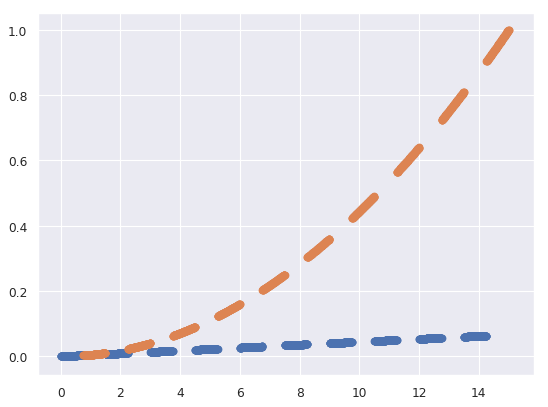

In [53]:
# Load Packages/Modules
exec(open('Init_Dump.py').read())
# Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Load Helper Function(s)
exec(open('Helper_Functions.py').read())
# Pre-process Data
if Option_Function != "Motivational_Example": 
    exec(open('Financial_Data_Preprocessor.py').read())
else:
    print(1)
    exec(open('Motivational_Example.py').read())
    print("Training Data size: ",X_train.shape[0])
# Import time separately
import time

### Set Seed

In [54]:
random.seed(2021)
tf.random.set_seed(2021)

#### Pre-Process:
- Convert Categorical Variables to Dummies
- Remove Bad Column
- Perform Training/Test Split

# Random Lipschitz Partition Builder

We implement the random paritioning method of [Yair Bartal](https://scholar.google.com/citations?user=eCXP24kAAAAJ&hl=en):
- [On approximating arbitrary metrices by tree metrics](https://dl.acm.org/doi/10.1145/276698.276725)

The algorithm is summarized as follow:

---

## Algorithm:
 1. Sample $\alpha \in [4^{-1},2^{-1}]$ randomly and uniformly,
 2. Apply a random suffle of the data, (a random bijection $\pi:\{i\}_{i=1}^X \rightarrow \mathbb{X}$),
 3. For $i = 1,\dots,I$:
   - Set $K_i\triangleq B\left(\pi(i),\alpha \Delta \right) - \bigcup_{j=1}^{i-1} P_j$
 
 4. Remove empty members of $\left\{K_i\right\}_{i=1}^X$.  
 
 **Return**: $\left\{K_i\right\}_{i=1}^{\tilde{X}}$.  
 
 For more details on the random-Lipschitz partition of Yair Bartal, see this [well-written blog post](https://nickhar.wordpress.com/2012/03/26/lecture-22-random-partitions-of-metric-spaces/).

## Define Random Partition Builder

In [55]:
from scipy.spatial import distance_matrix

Here we use $\Delta_{in} = Q_{q}\left(\Delta(\mathbb{X})\right)$ where $\Delta(\mathbb{X})$ is the vector of (Euclidean) distances between the given data-points, $q \in (0,1)$ is a hyper-parameter, and $Q$ is the empirical quantile function.

In [56]:
def Random_Lipschitz_Partioner(Min_data_size_percentage,q_in, X_train_in,y_train_in, CV_folds_failsafe, min_size):
       
    #-----------------------#
    # Reset Seed Internally #
    #-----------------------#
    random.seed(2020)
    np.random.seed(2020)

    #-------------------------------------------#
    #-------------------------------------------#
    # 1) Sample radius from unifom distribution #
    #-------------------------------------------#
    #-------------------------------------------#
    alpha = np.random.uniform(low=.25,high=.5,size=1)[0]

    #-------------------------------------#
    #-------------------------------------#
    # 2) Apply Random Bijection (Shuffle) #
    #-------------------------------------#
    #-------------------------------------#
    X_train_in_shuffled = X_train_in#.sample(frac=1)
    y_train_in_shuffled = y_train_in#.sample(frac=1)

    #--------------------#
    #--------------------#
    # X) Initializations #
    #--------------------#
    #--------------------#
    # Compute-data-driven radius
    Delta_X = distance_matrix(X_train_in_shuffled,X_train_in_shuffled)[::,0]
    Delta_in = np.quantile(Delta_X,q_in)

    # Initialize Random Radius
    rand_radius = Delta_in*alpha

    # Initialize Data_sizes & ratios
    N_tot = X_train_in.shape[0] #<- Total number of data-points in input data-set!
    N_radios = np.array([])
    N_pool_train_loop = N_tot
    # Initialize List of Dataframes
    X_internal_train_list = list()
    y_internal_train_list = list()

    # Initialize Partioned Data-pool
    X_internal_train_pool = X_train_in_shuffled
    y_internal_train_pool = y_train_in_shuffled

    # Initialize counter 
    part_current_loop = 0

    #----------------------------#
    #----------------------------#
    # 3) Iteratively Build Parts #
    #----------------------------#
    #----------------------------#

    while ((N_pool_train_loop/N_tot > Min_data_size_percentage) or (X_internal_train_pool.empty == False)):
        # Extract Current Center
        center_loop = X_internal_train_pool.iloc[0]
        # Compute Distances
        ## Training
        distances_pool_loop_train = X_internal_train_pool.sub(center_loop)
        distances_pool_loop_train = np.array(np.sqrt(np.square(distances_pool_loop_train).sum(axis=1)))
        # Evaluate which Distances are less than the given random radius
        Part_train_loop = X_internal_train_pool[distances_pool_loop_train<rand_radius]
        Part_train_loop_y = y_internal_train_pool[distances_pool_loop_train<rand_radius]

        # Remove all data-points which are "too small"
        if X_internal_train_pool.shape[0] > max(CV_folds,4):
            # Append Current part to list
            X_internal_train_list.append(Part_train_loop)
            y_internal_train_list.append(Part_train_loop_y)

        # Remove current part from pool 
        X_internal_train_pool = X_internal_train_pool[(np.logical_not(distances_pool_loop_train<rand_radius))]
        y_internal_train_pool = y_internal_train_pool[(np.logical_not(distances_pool_loop_train<rand_radius))]

        # Update Current size of pool of training data
        N_pool_train_loop = X_internal_train_pool.shape[0]
        N_radios = np.append(N_radios,(N_pool_train_loop/N_tot))

        # Update Counter
        part_current_loop = part_current_loop +1
        
        # Update User
        print((N_pool_train_loop/N_tot))


    # Post processing #
    #-----------------#
    # Remove Empty Partitions
    N_radios = N_radios[N_radios>0]
    
    
    #-----------------------------------------------------------------#
    # Combine parts which are too small to perform CV without an error
    #-----------------------------------------------------------------#
    # Initialize lists (partitions) with "enough" datums per part
    X_internal_train_list_good = list()
    y_internal_train_list_good = list()
    X_small_parts = list()
    y_small_parts = list()
    # Initialize first list item test
    is_first = True
    # Initialize counter
    goods_counter = 0
    for search_i in range(len(X_internal_train_list)):
        number_of_instances_in_part = len(X_internal_train_list[search_i]) 
        if number_of_instances_in_part < max(CV_folds_failsafe,min_size):
            # Check if first 
            if is_first:
                # Initialize set of small X_parts
                X_small_parts = X_internal_train_list[search_i]
                # Initialize set of small y_parts
                y_small_parts = y_internal_train_list[search_i]

                # Set is_first to false
                is_first = False
            else:
                X_small_parts = X_small_parts.append(X_internal_train_list[search_i])
                y_small_parts = np.append(y_small_parts,y_internal_train_list[search_i])
#                 y_small_parts = y_small_parts.append(y_internal_train_list[search_i])
        else:
            # Append to current list
            X_internal_train_list_good.append(X_internal_train_list[search_i])
            y_internal_train_list_good.append(y_internal_train_list[search_i])
            # Update goods counter 
            goods_counter = goods_counter +1

    # Append final one to good list
    X_internal_train_list_good.append(X_small_parts)
    y_internal_train_list_good.append(y_small_parts)

    # reset is_first to false (inscase we want to re-run this particular block)
    is_first = True

    # Set good lists to regular lists
    X_internal_train_list = X_internal_train_list_good
    y_internal_train_list = y_internal_train_list_good
    
    
    
    # Return Value #
    #--------------#
    return [X_internal_train_list, y_internal_train_list, N_radios]

# Apply Random Partitioner to the given Dataset

In [57]:
import time
partitioning_time_begin = time.time()

In [58]:
if Option_Function == 'SnP':
    q_in_auto = .8
    Min_data_size_percentage_auto = .1
    min_size_part = 100
else:
    if Option_Function == 'crypto':
        q_in_auto = .99
        Min_data_size_percentage_auto = .3
        min_size_part = 100
    if Option_Function == 'Motivational_Example':
        q_in_auto = .05
        Min_data_size_percentage_auto = .5
        min_size_part = 10
        # Partition Based on Y
        holder_temp = data_y
        data_y = X_train
        X_train = holder_temp
    else:
        q_in_auto = .5
        Min_data_size_percentage_auto = .3
        min_size_part = 100

In [59]:
# Initialize Number of Parts currently generated
N_parts_generated = 0

# Generate Partition (with option to regernerate if only 1 part is randomly produced)
while N_parts_generated < 2:
    # Generate Parts
    X_parts_list, y_parts_list, N_ratios = Random_Lipschitz_Partioner(Min_data_size_percentage=Min_data_size_percentage_auto, 
                                                                      q_in=q_in_auto, 
                                                                      X_train_in=X_train, 
                                                                      y_train_in=data_y, 
                                                                      CV_folds_failsafe=CV_folds,
                                                                      min_size = min_size_part)
    
    # Update Number of Parts
    N_parts_generated = len(X_parts_list)
    # Shuffle hyperparameters
    Min_data_size_percentage_auto = (Min_data_size_percentage_auto + random.uniform(0,.3)) % 1
    q_in_auto = (q_in_auto + random.uniform(0,.3)) % 1
    
    # Update User
    print('The_parts_listhe number of parts are: ' + str(len(X_parts_list))+'.')
    
# Trash removal (removes empty parts)
X_parts_list = list(filter(([]).__ne__, X_parts_list))
y_parts_list = list(filter(([]).__ne__, y_parts_list))
    
    
# ICML Rebuttle Deadline = Coersion!
if Option_Function == 'Motivational_Example':
    # Flipback After Partitioning Based on Y (since code was made for partitioning in X!)
    holder_temp = data_y
    data_y = X_train
    X_train = holder_temp
    holder_temp = y_parts_list
    y_parts_list = X_parts_list
    X_parts_list = holder_temp

0.9773333333333334
0.95
0.9326666666666666
0.8916666666666667
0.8613333333333333
0.8543333333333333
0.8316666666666667
0.809
0.804
0.7813333333333333
0.7573333333333333
0.7473333333333333
0.715
0.688
0.679
0.6483333333333333
0.6216666666666667
0.6126666666666667
0.5863333333333334
0.5636666666666666
0.5586666666666666
0.536
0.5133333333333333
0.5083333333333333
0.4856666666666667
0.46266666666666667
0.458
0.43533333333333335
0.412
0.404
0.3993333333333333
0.3973333333333333
0.3953333333333333
0.39366666666666666
0.39066666666666666
0.3873333333333333
0.384
0.381
0.378
0.375
0.372
0.36933333333333335
0.36633333333333334
0.3636666666666667
0.361
0.35833333333333334
0.3556666666666667
0.3526666666666667
0.35
0.3476666666666667
0.3456666666666667
0.3433333333333333
0.341
0.33866666666666667
0.3363333333333333
0.334
0.33166666666666667
0.3293333333333333
0.3273333333333333
0.325
0.32266666666666666
0.32066666666666666
0.31833333333333336
0.31633333333333336
0.31433333333333335
0.312
0.31
0.

In [60]:
partitioning_time = time.time() - partitioning_time_begin

In [61]:
print('The_parts_listhe number of parts are: ' + str(len(X_parts_list))+'.')

The_parts_listhe number of parts are: 34.


#### Building Training Predictions on each part
- Train locally (on each "naive part")
- Generate predictions for (full) training and testings sets respectively, to be used in training the classifer and for prediction, respectively.  
- Generate predictions on all of testing-set (will be selected between later using classifier)

In [62]:
# Time-Elapse (Start) for Training on Each Part
Architope_partition_training_begin = time.time()
# Initialize running max for Parallel time
Architope_partitioning_max_time_running = -math.inf # Initialize slowest-time at - infinity to force updating!
# Initialize N_parameter counter for Architope
N_params_Architope = 0

In [63]:
# Silly Coercsion for ICML rebuttle deadline timeline
if Option_Function == 'Motivational_Example':
    Iteration_Length = len(X_parts_list) -1
else:
    Iteration_Length = len(X_parts_list)

    
# Train each part!
for current_part in range(Iteration_Length):
    #==============#
    # Timer(begin) #
    #==============#
    current_part_training_time_for_parallel_begin = time.time()
    
    
    # Initializations #
    #-----------------#
    # Reload Grid
    exec(open('Grid_Enhanced_Network.py').read())
    # Modify heights according to optimal (data-driven) rule (with threshold)
    current_height = np.ceil(np.array(param_grid_Vanilla_Nets['height'])*N_ratios[current_part])
    current_height_threshold = np.repeat(min_height,(current_height.shape[0]))
    current_height = np.maximum(current_height,current_height_threshold)
    current_height = current_height.astype(int).tolist()
    param_grid_Vanilla_Nets['height'] = current_height
    # Automatically Fix Input Dimension
    param_grid_Vanilla_Nets['input_dim'] = [X_train.shape[1]]
    param_grid_Vanilla_Nets['output_dim'] = [1]
    
    # Update User #
    #-------------#
    print('Status: Current part: ' + str(current_part) + ' out of : '+str(len(X_parts_list)) +' parts.')
    print('Heights to iterate over: '+str(current_height))
    
    # Generate Prediction(s) on current Part #
    #----------------------------------------#
    # Failsafe (number of data-points)
    CV_folds_failsafe = min(CV_folds,max(1,(X_train.shape[0]-1)))
    # Train Network
    y_hat_train_full_loop, y_hat_test_full_loop, N_params_Architope_loop = build_ffNN(n_folds = CV_folds_failsafe, 
                                                                                     n_jobs = n_jobs,
                                                                                     n_iter = n_iter, 
                                                                                     param_grid_in = param_grid_Vanilla_Nets, 
                                                                                     X_train= X_parts_list[current_part], 
                                                                                     y_train=y_parts_list[current_part],
                                                                                     X_test_partial=X_train,
                                                                                     X_test=X_test)
    
    # Append predictions to data-frames
    ## If first prediction we initialize data-frames
    if current_part==0:
        # Register quality
        training_quality = np.array(np.abs(y_hat_train_full_loop-y_train))
        training_quality = training_quality.reshape(training_quality.shape[0],1)

        # Save Predictions
        predictions_train = y_hat_train_full_loop
        predictions_train = predictions_train.reshape(predictions_train.shape[0],1)
        predictions_test = y_hat_test_full_loop
        predictions_test = predictions_test.reshape(predictions_test.shape[0],1)
        
        
    ## If not first prediction we append to already initialized dataframes
    else:
    # Register Best Scores
        #----------------------#
        # Write Predictions 
        # Save Predictions
        y_hat_train_loop = y_hat_train_full_loop.reshape(predictions_train.shape[0],1)
        predictions_train = np.append(predictions_train,y_hat_train_loop,axis=1)
        y_hat_test_loop = y_hat_test_full_loop.reshape(predictions_test.shape[0],1)
        predictions_test = np.append(predictions_test,y_hat_test_loop,axis=1)
        
        # Evaluate Errors #
        #-----------------#
        # Training
        prediction_errors = np.abs(y_hat_train_loop.reshape(-1,)-y_train)
        training_quality = np.append(training_quality,prediction_errors.reshape(training_quality.shape[0],1),axis=1)
        
    #============#
    # Timer(end) #
    #============#
    current_part_training_time_for_parallel = time.time() - current_part_training_time_for_parallel_begin
    Architope_partitioning_max_time_running = max(Architope_partitioning_max_time_running,current_part_training_time_for_parallel)

    #============---===============#
    # N_parameter Counter (Update) #
    #------------===---------------#
    N_params_Architope = N_params_Architope + N_params_Architope_loop

# Update User
#-------------#
print(' ')
print(' ')
print(' ')
print('----------------------------------------------------')
print('Feature Generation (Learning Phase): Score Generated')
print('----------------------------------------------------')
print(' ')
print(' ')
print(' ')

Status: Current part: 0 out of : 34 parts.
Heights to iterate over: [98]
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.4s finished


Epoch 1/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0556 - mse: 0.0031 - mae: 0.0556 - mape: 21648.4688
Epoch 2/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0524 - mse: 0.0027 - mae: 0.0524 - mape: 20606.9512
Epoch 3/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0492 - mse: 0.0024 - mae: 0.0492 - mape: 19330.7793
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0460 - mse: 0.0021 - mae: 0.0460 - mape: 18036.8047
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0428 - mse: 0.0018 - mae: 0.0428 - mape: 16800.1055
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0396 - mse: 0.0016 - mae: 0.0396 - mape: 15569.1123
Epoch 7/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0364 - mse: 0.0013 - mae: 0.0364 - mape: 14318.5820
Epoch 8/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0331 - mse: 0.0011 - mae: 0.0331 - mape: 12938.5566
Epoch 9/

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.3s finished


Epoch 1/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0125 - mse: 1.5620e-04 - mae: 0.0125 - mape: 552.4705
Epoch 2/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0096 - mse: 9.2247e-05 - mae: 0.0096 - mape: 424.1752
Epoch 3/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0067 - mse: 4.5136e-05 - mae: 0.0067 - mape: 294.9401
Epoch 4/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0038 - mse: 1.4672e-05 - mae: 0.0038 - mape: 168.0660
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 1.3558e-06 - mae: 0.0010 - mape: 44.3074
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0015 - mse: 2.6658e-06 - mae: 0.0015 - mape: 64.2759
Epoch 7/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0023 - mse: 5.4469e-06 - mae: 0.0023 - mape: 97.8143
Epoch 8/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0019 - mse: 3.8299e-06 - mae: 0.0019 - mape: 80.1

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.0s finished


Epoch 1/50
2/2 [==============================] - 0s 3ms/step - loss: 0.0702 - mse: 0.0049 - mae: 0.0702 - mape: 1983.8458
Epoch 2/50
2/2 [==============================] - 0s 1ms/step - loss: 0.0683 - mse: 0.0047 - mae: 0.0683 - mape: 1929.9390
Epoch 3/50
2/2 [==============================] - 0s 2ms/step - loss: 0.0664 - mse: 0.0044 - mae: 0.0664 - mape: 1875.8622
Epoch 4/50
2/2 [==============================] - 0s 2ms/step - loss: 0.0644 - mse: 0.0042 - mae: 0.0644 - mape: 1821.9396
Epoch 5/50
2/2 [==============================] - 0s 2ms/step - loss: 0.0625 - mse: 0.0039 - mae: 0.0625 - mape: 1767.6561
Epoch 6/50
2/2 [==============================] - 0s 2ms/step - loss: 0.0606 - mse: 0.0037 - mae: 0.0606 - mape: 1713.3098
Epoch 7/50
2/2 [==============================] - 0s 2ms/step - loss: 0.0587 - mse: 0.0034 - mae: 0.0587 - mape: 1658.2548
Epoch 8/50
2/2 [==============================] - 0s 2ms/step - loss: 0.0567 - mse: 0.0032 - mae: 0.0567 - mape: 1603.8479
Epoch 9/50
2/2 [

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.7s finished


Epoch 1/50
4/4 [==============================] - 0s 2ms/step - loss: 0.0814 - mse: 0.0066 - mae: 0.0814 - mape: 1167.4281
Epoch 2/50
4/4 [==============================] - 0s 2ms/step - loss: 0.0774 - mse: 0.0060 - mae: 0.0774 - mape: 1109.7726
Epoch 3/50
4/4 [==============================] - 0s 2ms/step - loss: 0.0733 - mse: 0.0054 - mae: 0.0733 - mape: 1052.2391
Epoch 4/50
4/4 [==============================] - 0s 2ms/step - loss: 0.0693 - mse: 0.0048 - mae: 0.0693 - mape: 994.3900
Epoch 5/50
4/4 [==============================] - 0s 2ms/step - loss: 0.0653 - mse: 0.0043 - mae: 0.0653 - mape: 936.1849
Epoch 6/50
4/4 [==============================] - 0s 2ms/step - loss: 0.0611 - mse: 0.0037 - mae: 0.0611 - mape: 877.9105
Epoch 7/50
4/4 [==============================] - 0s 2ms/step - loss: 0.0570 - mse: 0.0033 - mae: 0.0570 - mape: 818.6669
Epoch 8/50
4/4 [==============================] - 0s 2ms/step - loss: 0.0528 - mse: 0.0028 - mae: 0.0528 - mape: 758.6511
Epoch 9/50
4/4 [=====

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.2s finished


Epoch 1/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0134 - mse: 1.8266e-04 - mae: 0.0134 - mape: 150.2098
Epoch 2/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0100 - mse: 1.0377e-04 - mae: 0.0100 - mape: 112.3573
Epoch 3/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0066 - mse: 4.8897e-05 - mae: 0.0066 - mape: 73.8088
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0032 - mse: 1.6286e-05 - mae: 0.0032 - mape: 35.6261
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0022 - mse: 6.8616e-06 - mae: 0.0022 - mape: 24.2761
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0032 - mse: 1.0864e-05 - mae: 0.0032 - mape: 36.0497
Epoch 7/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0035 - mse: 1.3148e-05 - mae: 0.0035 - mape: 39.2873
Epoch 8/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0033 - mse: 1.1501e-05 - mae: 0.0033 - mape: 37.081

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.1s finished


Epoch 1/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0807 - mse: 0.0065 - mae: 0.0807 - mape: 820.0897
Epoch 2/50
1/1 [==============================] - 0s 2ms/step - loss: 0.0795 - mse: 0.0063 - mae: 0.0795 - mape: 808.3627
Epoch 3/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0784 - mse: 0.0061 - mae: 0.0784 - mape: 796.6278
Epoch 4/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0772 - mse: 0.0060 - mae: 0.0772 - mape: 784.8887
Epoch 5/50
1/1 [==============================] - 0s 4ms/step - loss: 0.0761 - mse: 0.0058 - mae: 0.0761 - mape: 773.1459
Epoch 6/50
1/1 [==============================] - 0s 2ms/step - loss: 0.0749 - mse: 0.0056 - mae: 0.0749 - mape: 761.3987
Epoch 7/50
1/1 [==============================] - 0s 2ms/step - loss: 0.0737 - mse: 0.0054 - mae: 0.0737 - mape: 749.6454
Epoch 8/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0726 - mse: 0.0053 - mae: 0.0726 - mape: 737.8851
Epoch 9/50
1/1 [========

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.1s finished


Epoch 1/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0107 - mse: 1.1562e-04 - mae: 0.0107 - mape: 75.9859
Epoch 2/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0061 - mse: 3.8456e-05 - mae: 0.0061 - mape: 43.4754
Epoch 3/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 3.2467e-06 - mae: 0.0016 - mape: 11.5294
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0020 - mse: 4.2130e-06 - mae: 0.0020 - mape: 14.3754
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0026 - mse: 6.7134e-06 - mae: 0.0026 - mape: 18.3966
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0014 - mse: 1.9987e-06 - mae: 0.0014 - mape: 9.6582
Epoch 7/50
3/3 [==============================] - 0s 2ms/step - loss: 7.2835e-04 - mse: 6.3931e-07 - mae: 7.2835e-04 - mape: 5.1425
Epoch 8/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0013 - mse: 1.7760e-06 - mae: 0.0013 - mape: 9.

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.3s finished


Epoch 1/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0604 - mse: 0.0037 - mae: 0.0604 - mape: 387.6159
Epoch 2/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0562 - mse: 0.0032 - mae: 0.0562 - mape: 360.8056
Epoch 3/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0521 - mse: 0.0027 - mae: 0.0521 - mape: 333.9094
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0478 - mse: 0.0023 - mae: 0.0478 - mape: 306.9233
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0436 - mse: 0.0019 - mae: 0.0436 - mape: 279.8287
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0394 - mse: 0.0016 - mae: 0.0394 - mape: 252.5602
Epoch 7/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0351 - mse: 0.0012 - mae: 0.0351 - mape: 225.0855
Epoch 8/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0308 - mse: 9.4690e-04 - mae: 0.0308 - mape: 197.3907
Epoch 9/50
3/3 [====

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.2s finished


Epoch 1/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0628 - mse: 0.0039 - mae: 0.0628 - mape: 380.2368
Epoch 2/50
1/1 [==============================] - 0s 2ms/step - loss: 0.0611 - mse: 0.0037 - mae: 0.0611 - mape: 369.5521
Epoch 3/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0593 - mse: 0.0035 - mae: 0.0593 - mape: 358.8696
Epoch 4/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0575 - mse: 0.0033 - mae: 0.0575 - mape: 348.1909
Epoch 5/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0558 - mse: 0.0031 - mae: 0.0558 - mape: 337.5158
Epoch 6/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0540 - mse: 0.0029 - mae: 0.0540 - mape: 326.8441
Epoch 7/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0522 - mse: 0.0027 - mae: 0.0522 - mape: 316.1748
Epoch 8/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0505 - mse: 0.0025 - mae: 0.0505 - mape: 305.5073
Epoch 9/50
1/1 [========

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.1s finished


Epoch 1/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0276 - mse: 7.6190e-04 - mae: 0.0276 - mape: 132.9008
Epoch 2/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0223 - mse: 4.9674e-04 - mae: 0.0223 - mape: 107.2746
Epoch 3/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0169 - mse: 2.8751e-04 - mae: 0.0169 - mape: 81.5426
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0116 - mse: 1.3471e-04 - mae: 0.0116 - mape: 55.6820
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0062 - mse: 3.9051e-05 - mae: 0.0062 - mape: 29.6695
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 9.9331e-04 - mse: 1.6779e-06 - mae: 9.9331e-04 - mape: 4.7941
Epoch 7/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0033 - mse: 1.0874e-05 - mae: 0.0033 - mape: 15.7074
Epoch 8/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0043 - mse: 1.8811e-05 - mae: 0.0043 - mape:

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.1s finished


Epoch 1/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0643 - mse: 0.0041 - mae: 0.0643 - mape: 288.2469
Epoch 2/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0584 - mse: 0.0034 - mae: 0.0584 - mape: 261.9708
Epoch 3/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0525 - mse: 0.0028 - mae: 0.0525 - mape: 235.6864
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0467 - mse: 0.0022 - mae: 0.0467 - mape: 209.4772
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0409 - mse: 0.0017 - mae: 0.0409 - mape: 183.2611
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0350 - mse: 0.0012 - mae: 0.0350 - mape: 156.9665
Epoch 7/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0291 - mse: 8.6705e-04 - mae: 0.0291 - mape: 130.6688
Epoch 8/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0232 - mse: 5.6353e-04 - mae: 0.0232 - mape: 104.2175
Epoch 9/50
3/3 [

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.0s finished


Epoch 1/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0367 - mse: 0.0013 - mae: 0.0367 - mape: 156.1794
Epoch 2/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0352 - mse: 0.0012 - mae: 0.0352 - mape: 149.9805
Epoch 3/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0338 - mse: 0.0011 - mae: 0.0338 - mape: 143.7764
Epoch 4/50
1/1 [==============================] - 0s 2ms/step - loss: 0.0323 - mse: 0.0010 - mae: 0.0323 - mape: 137.5681
Epoch 5/50
1/1 [==============================] - 0s 2ms/step - loss: 0.0309 - mse: 9.5956e-04 - mae: 0.0309 - mape: 131.3557
Epoch 6/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0294 - mse: 8.7387e-04 - mae: 0.0294 - mape: 125.1386
Epoch 7/50
1/1 [==============================] - 0s 918us/step - loss: 0.0280 - mse: 7.9260e-04 - mae: 0.0280 - mape: 118.9161
Epoch 8/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0265 - mse: 7.1574e-04 - mae: 0.0265 - mape: 112.6872
Epoch 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.4s finished


Epoch 1/50
4/4 [==============================] - 0s 2ms/step - loss: 0.0168 - mse: 3.3637e-04 - mae: 0.0168 - mape: 61.5572
Epoch 2/50
4/4 [==============================] - 0s 2ms/step - loss: 0.0086 - mse: 9.9123e-05 - mae: 0.0086 - mape: 31.4582
Epoch 3/50
4/4 [==============================] - 0s 2ms/step - loss: 0.0026 - mse: 9.7187e-06 - mae: 0.0026 - mape: 9.5459
Epoch 4/50
4/4 [==============================] - 0s 2ms/step - loss: 0.0042 - mse: 1.9615e-05 - mae: 0.0042 - mape: 15.3673
Epoch 5/50
4/4 [==============================] - 0s 1ms/step - loss: 0.0033 - mse: 1.4156e-05 - mae: 0.0033 - mape: 12.3104
Epoch 6/50
4/4 [==============================] - 0s 2ms/step - loss: 0.0020 - mse: 5.6343e-06 - mae: 0.0020 - mape: 7.3038
Epoch 7/50
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - mse: 8.7793e-06 - mae: 0.0029 - mape: 10.6891
Epoch 8/50
4/4 [==============================] - 0s 1ms/step - loss: 0.0022 - mse: 5.4004e-06 - mae: 0.0022 - mape: 7.9552
Epo

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.7s finished


Epoch 1/50
3/3 [==============================] - 0s 3ms/step - loss: 0.1016 - mse: 0.0103 - mae: 0.1016 - mape: 350.8997
Epoch 2/50
3/3 [==============================] - 0s 4ms/step - loss: 0.0968 - mse: 0.0094 - mae: 0.0968 - mape: 334.3498
Epoch 3/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0920 - mse: 0.0085 - mae: 0.0920 - mape: 317.7650
Epoch 4/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0871 - mse: 0.0076 - mae: 0.0871 - mape: 300.9232
Epoch 5/50
3/3 [==============================] - 0s 4ms/step - loss: 0.0823 - mse: 0.0068 - mae: 0.0823 - mape: 284.2486
Epoch 6/50
3/3 [==============================] - 0s 4ms/step - loss: 0.0774 - mse: 0.0060 - mae: 0.0774 - mape: 267.3308
Epoch 7/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0725 - mse: 0.0053 - mae: 0.0725 - mape: 250.5081
Epoch 8/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0676 - mse: 0.0046 - mae: 0.0676 - mape: 233.6031
Epoch 9/50
3/3 [========

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.0s finished


Epoch 1/50
1/1 [==============================] - 0s 1ms/step - loss: 0.1092 - mse: 0.0120 - mae: 0.1092 - mape: 362.5734
Epoch 2/50
1/1 [==============================] - 0s 1ms/step - loss: 0.1077 - mse: 0.0116 - mae: 0.1077 - mape: 357.4539
Epoch 3/50
1/1 [==============================] - 0s 2ms/step - loss: 0.1062 - mse: 0.0113 - mae: 0.1062 - mape: 352.3308
Epoch 4/50
1/1 [==============================] - 0s 4ms/step - loss: 0.1046 - mse: 0.0110 - mae: 0.1046 - mape: 347.2049
Epoch 5/50
1/1 [==============================] - 0s 1ms/step - loss: 0.1031 - mse: 0.0106 - mae: 0.1031 - mape: 342.0762
Epoch 6/50
1/1 [==============================] - 0s 1ms/step - loss: 0.1015 - mse: 0.0103 - mae: 0.1015 - mape: 336.9442
Epoch 7/50
1/1 [==============================] - 0s 1ms/step - loss: 0.1000 - mse: 0.0100 - mae: 0.1000 - mape: 331.8088
Epoch 8/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0985 - mse: 0.0097 - mae: 0.0985 - mape: 326.6695
Epoch 9/50
1/1 [========

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    2.0s finished


Epoch 1/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0193 - mse: 3.7522e-04 - mae: 0.0193 - mape: 56.9943
Epoch 2/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0156 - mse: 2.4580e-04 - mae: 0.0156 - mape: 46.1734
Epoch 3/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0119 - mse: 1.4512e-04 - mae: 0.0119 - mape: 35.3144
Epoch 4/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0082 - mse: 7.3199e-05 - mae: 0.0082 - mape: 24.3522
Epoch 5/50
3/3 [==============================] - 0s 4ms/step - loss: 0.0045 - mse: 3.0506e-05 - mae: 0.0045 - mape: 13.3821
Epoch 6/50
3/3 [==============================] - 0s 4ms/step - loss: 0.0031 - mse: 1.7840e-05 - mae: 0.0031 - mape: 9.2461
Epoch 7/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0046 - mse: 2.2674e-05 - mae: 0.0046 - mape: 13.5414
Epoch 8/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0049 - mse: 2.4930e-05 - mae: 0.0049 - mape: 14.4960
E

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.2s finished


Epoch 1/50
3/3 [==============================] - 0s 2ms/step - loss: 0.1162 - mse: 0.0135 - mae: 0.1162 - mape: 326.2881
Epoch 2/50
3/3 [==============================] - 0s 3ms/step - loss: 0.1097 - mse: 0.0120 - mae: 0.1097 - mape: 308.0688
Epoch 3/50
3/3 [==============================] - 0s 3ms/step - loss: 0.1033 - mse: 0.0107 - mae: 0.1033 - mape: 290.0336
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0969 - mse: 0.0094 - mae: 0.0969 - mape: 272.1483
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0905 - mse: 0.0082 - mae: 0.0905 - mape: 254.2460
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0839 - mse: 0.0071 - mae: 0.0839 - mape: 235.8066
Epoch 7/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0776 - mse: 0.0060 - mae: 0.0776 - mape: 217.9655
Epoch 8/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0711 - mse: 0.0051 - mae: 0.0711 - mape: 199.6993
Epoch 9/50
3/3 [========

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.1s finished


Epoch 1/50
1/1 [==============================] - 0s 958us/step - loss: 0.0835 - mse: 0.0070 - mae: 0.0835 - mape: 226.8834
Epoch 2/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0817 - mse: 0.0067 - mae: 0.0817 - mape: 221.9694
Epoch 3/50
1/1 [==============================] - 0s 993us/step - loss: 0.0799 - mse: 0.0064 - mae: 0.0799 - mape: 217.0588
Epoch 4/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0781 - mse: 0.0061 - mae: 0.0781 - mape: 212.1509
Epoch 5/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0763 - mse: 0.0058 - mae: 0.0763 - mape: 207.2443
Epoch 6/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0745 - mse: 0.0055 - mae: 0.0745 - mape: 202.3376
Epoch 7/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0727 - mse: 0.0053 - mae: 0.0727 - mape: 197.4298
Epoch 8/50
1/1 [==============================] - 0s 2ms/step - loss: 0.0709 - mse: 0.0050 - mae: 0.0709 - mape: 192.5199
Epoch 9/50
1/1 [====

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.1s finished


Epoch 1/50
3/3 [==============================] - 0s 4ms/step - loss: 0.0077 - mse: 6.2854e-05 - mae: 0.0077 - mape: 19.0522
Epoch 2/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0025 - mse: 1.2135e-05 - mae: 0.0025 - mape: 6.1905
Epoch 3/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0036 - mse: 1.4428e-05 - mae: 0.0036 - mape: 8.8232
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0034 - mse: 1.3253e-05 - mae: 0.0034 - mape: 8.3372
Epoch 5/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0017 - mse: 8.3128e-06 - mae: 0.0017 - mape: 4.3624
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0024 - mse: 1.1063e-05 - mae: 0.0024 - mape: 5.9038
Epoch 7/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 8.8093e-06 - mae: 0.0017 - mape: 4.2188
Epoch 8/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0018 - mse: 7.5904e-06 - mae: 0.0018 - mape: 4.4997
Epoch 9

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.0s finished


Epoch 1/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0649 - mse: 0.0042 - mae: 0.0649 - mape: 153.4855
Epoch 2/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0592 - mse: 0.0035 - mae: 0.0592 - mape: 140.0252
Epoch 3/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0535 - mse: 0.0029 - mae: 0.0535 - mape: 126.6137
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0479 - mse: 0.0023 - mae: 0.0479 - mape: 113.2429
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0422 - mse: 0.0018 - mae: 0.0422 - mape: 99.8982
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0366 - mse: 0.0013 - mae: 0.0366 - mape: 86.5580
Epoch 7/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0309 - mse: 9.5874e-04 - mae: 0.0309 - mape: 73.2037
Epoch 8/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0253 - mse: 6.4049e-04 - mae: 0.0253 - mape: 59.8183
Epoch 9/50
3/3 [====

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.0s finished


Epoch 1/50
1/1 [==============================] - 0s 1ms/step - loss: 0.1203 - mse: 0.0145 - mae: 0.1203 - mape: 278.5447
Epoch 2/50
1/1 [==============================] - 0s 884us/step - loss: 0.1184 - mse: 0.0140 - mae: 0.1184 - mape: 274.1740
Epoch 3/50
1/1 [==============================] - 0s 1ms/step - loss: 0.1165 - mse: 0.0136 - mae: 0.1165 - mape: 269.8037
Epoch 4/50
1/1 [==============================] - 0s 1ms/step - loss: 0.1146 - mse: 0.0131 - mae: 0.1146 - mape: 265.4334
Epoch 5/50
1/1 [==============================] - 0s 1ms/step - loss: 0.1128 - mse: 0.0127 - mae: 0.1128 - mape: 261.0630
Epoch 6/50
1/1 [==============================] - 0s 1ms/step - loss: 0.1109 - mse: 0.0123 - mae: 0.1109 - mape: 256.6922
Epoch 7/50
1/1 [==============================] - 0s 2ms/step - loss: 0.1090 - mse: 0.0119 - mae: 0.1090 - mape: 252.3208
Epoch 8/50
1/1 [==============================] - 0s 1ms/step - loss: 0.1071 - mse: 0.0115 - mae: 0.1071 - mape: 247.9485
Epoch 9/50
1/1 [======

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.3s finished


Epoch 1/50
3/3 [==============================] - 0s 2ms/step - loss: 0.1076 - mse: 0.0116 - mae: 0.1076 - mape: 226.8429
Epoch 2/50
3/3 [==============================] - 0s 2ms/step - loss: 0.1017 - mse: 0.0103 - mae: 0.1017 - mape: 214.4861
Epoch 3/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0959 - mse: 0.0092 - mae: 0.0959 - mape: 202.1508
Epoch 4/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0900 - mse: 0.0081 - mae: 0.0900 - mape: 189.8311
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0842 - mse: 0.0071 - mae: 0.0842 - mape: 177.5179
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0783 - mse: 0.0061 - mae: 0.0783 - mape: 165.1957
Epoch 7/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0725 - mse: 0.0053 - mae: 0.0725 - mape: 152.8511
Epoch 8/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0666 - mse: 0.0044 - mae: 0.0666 - mape: 140.4719
Epoch 9/50
3/3 [========

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.5s finished


Epoch 1/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0730 - mse: 0.0053 - mae: 0.0730 - mape: 149.2115
Epoch 2/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0684 - mse: 0.0047 - mae: 0.0684 - mape: 139.7614
Epoch 3/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0638 - mse: 0.0041 - mae: 0.0638 - mape: 130.2847
Epoch 4/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0591 - mse: 0.0035 - mae: 0.0591 - mape: 120.7718
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0544 - mse: 0.0030 - mae: 0.0544 - mape: 111.2109
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0497 - mse: 0.0025 - mae: 0.0497 - mape: 101.5829
Epoch 7/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0450 - mse: 0.0020 - mae: 0.0450 - mape: 91.8689
Epoch 8/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0401 - mse: 0.0016 - mae: 0.0401 - mape: 82.0511
Epoch 9/50
3/3 [==========

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.2s finished


Epoch 1/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0100 - mse: 1.0058e-04 - mae: 0.0100 - mape: 20.1149
Epoch 2/50
1/1 [==============================] - 0s 979us/step - loss: 0.0083 - mse: 6.9663e-05 - mae: 0.0083 - mape: 16.7398
Epoch 3/50
1/1 [==============================] - 0s 3ms/step - loss: 0.0067 - mse: 4.4382e-05 - mae: 0.0067 - mape: 13.3613
Epoch 4/50
1/1 [==============================] - 0s 3ms/step - loss: 0.0050 - mse: 2.4757e-05 - mae: 0.0050 - mape: 9.9788
Epoch 5/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0033 - mse: 1.0807e-05 - mae: 0.0033 - mape: 6.5924
Epoch 6/50
1/1 [==============================] - 0s 6ms/step - loss: 0.0016 - mse: 2.5516e-06 - mae: 0.0016 - mape: 3.2017
Epoch 7/50
1/1 [==============================] - 0s 1ms/step - loss: 9.6313e-05 - mse: 1.2093e-08 - mae: 9.6313e-05 - mape: 0.1934
Epoch 8/50
1/1 [==============================] - 0s 2ms/step - loss: 0.0011 - mse: 1.2979e-06 - mae: 0.0011 - mape: 2.

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.4s finished


Epoch 1/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0106 - mse: 1.1284e-04 - mae: 0.0106 - mape: 19.5217
Epoch 2/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0053 - mse: 2.9767e-05 - mae: 0.0053 - mape: 9.8706
Epoch 3/50
3/3 [==============================] - 0s 2ms/step - loss: 9.1288e-04 - mse: 1.0799e-06 - mae: 9.1288e-04 - mape: 1.6892
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0026 - mse: 6.7512e-06 - mae: 0.0026 - mape: 4.7656
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0022 - mse: 4.8598e-06 - mae: 0.0022 - mape: 3.9994
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 5.1704e-04 - mse: 3.7663e-07 - mae: 5.1704e-04 - mape: 0.9563
Epoch 7/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0015 - mse: 2.2310e-06 - mae: 0.0015 - mape: 2.6831
Epoch 8/50
3/3 [==============================] - 0s 2ms/step - loss: 9.3100e-04 - mse: 1.0329e-06 - mae: 9.3100e-0

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.1s finished


Epoch 1/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0055 - mse: 3.1533e-05 - mae: 0.0055 - mape: 9.8701
Epoch 2/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 1.1860e-06 - mae: 0.0010 - mape: 1.8877    
Epoch 3/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0023 - mse: 5.3073e-06 - mae: 0.0023 - mape: 4.1369
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 7.8602e-04 - mse: 7.8920e-07 - mae: 7.8602e-04 - mape: 1.4138
Epoch 5/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0014 - mse: 1.9018e-06 - mae: 0.0014 - mape: 2.4591
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 9.1404e-04 - mse: 9.4604e-07 - mae: 9.1404e-04 - mape: 1.6422
Epoch 7/50
3/3 [==============================] - 0s 2ms/step - loss: 9.5274e-04 - mse: 9.7700e-07 - mae: 9.5274e-04 - mape: 1.7141
Epoch 8/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0012 - mse: 1.3908e-06 - mae: 0.

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.0s finished


Epoch 1/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0412 - mse: 0.0017 - mae: 0.0412 - mape: 72.8878
Epoch 2/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0392 - mse: 0.0015 - mae: 0.0392 - mape: 69.4012
Epoch 3/50
1/1 [==============================] - 0s 948us/step - loss: 0.0373 - mse: 0.0014 - mae: 0.0373 - mape: 65.9107
Epoch 4/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0353 - mse: 0.0012 - mae: 0.0353 - mape: 62.4164
Epoch 5/50
1/1 [==============================] - 0s 2ms/step - loss: 0.0333 - mse: 0.0011 - mae: 0.0333 - mape: 58.9180
Epoch 6/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0313 - mse: 9.8163e-04 - mae: 0.0313 - mape: 55.4150
Epoch 7/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0293 - mse: 8.6127e-04 - mae: 0.0293 - mape: 51.9066
Epoch 8/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0274 - mse: 7.4858e-04 - mae: 0.0274 - mape: 48.3918
Epoch 9/50
1/1 [==

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.1s finished


Epoch 1/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0163 - mse: 2.6709e-04 - mae: 0.0163 - mape: 26.7878
Epoch 2/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0097 - mse: 9.6787e-05 - mae: 0.0097 - mape: 16.0198
Epoch 3/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0032 - mse: 1.2138e-05 - mae: 0.0032 - mape: 5.3056
Epoch 4/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0022 - mse: 5.6510e-06 - mae: 0.0022 - mape: 3.7074
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0035 - mse: 1.2110e-05 - mae: 0.0035 - mape: 5.6874
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0019 - mse: 4.0221e-06 - mae: 0.0019 - mape: 3.1077
Epoch 7/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 1.4114e-06 - mae: 0.0010 - mape: 1.6857    
Epoch 8/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0019 - mse: 3.6435e-06 - mae: 0.0019 - mape: 3.0466
Ep

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.0s finished


Epoch 1/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0034 - mse: 1.4321e-05 - mae: 0.0034 - mape: 5.3821
Epoch 2/50
3/3 [==============================] - 0s 2ms/step - loss: 0.0017 - mse: 3.0731e-06 - mae: 0.0017 - mape: 2.6946
Epoch 3/50
3/3 [==============================] - 0s 1ms/step - loss: 7.0787e-04 - mse: 7.5612e-07 - mae: 7.0787e-04 - mape: 1.1341
Epoch 4/50
3/3 [==============================] - 0s 1ms/step - loss: 8.0439e-04 - mse: 8.9364e-07 - mae: 8.0439e-04 - mape: 1.2877
Epoch 5/50
3/3 [==============================] - 0s 1ms/step - loss: 0.0012 - mse: 1.6425e-06 - mae: 0.0012 - mape: 1.8872    
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 6.5160e-04 - mse: 6.1753e-07 - mae: 6.5160e-04 - mape: 1.0485
Epoch 7/50
3/3 [==============================] - 0s 2ms/step - loss: 8.5070e-04 - mse: 9.8286e-07 - mae: 8.5070e-04 - mape: 1.3606
Epoch 8/50
3/3 [==============================] - 0s 2ms/step - loss: 6.6172e-04 - mse: 6.4021e-

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.1s finished


Epoch 1/50
1/1 [==============================] - 0s 1ms/step - loss: 0.1452 - mse: 0.0211 - mae: 0.1452 - mape: 228.9339
Epoch 2/50
1/1 [==============================] - 0s 2ms/step - loss: 0.1433 - mse: 0.0206 - mae: 0.1433 - mape: 226.0460
Epoch 3/50
1/1 [==============================] - 0s 1ms/step - loss: 0.1415 - mse: 0.0200 - mae: 0.1415 - mape: 223.1606
Epoch 4/50
1/1 [==============================] - 0s 3ms/step - loss: 0.1397 - mse: 0.0195 - mae: 0.1397 - mape: 220.2776
Epoch 5/50
1/1 [==============================] - 0s 1ms/step - loss: 0.1379 - mse: 0.0190 - mae: 0.1379 - mape: 217.3971
Epoch 6/50
1/1 [==============================] - 0s 2ms/step - loss: 0.1361 - mse: 0.0185 - mae: 0.1361 - mape: 214.5189
Epoch 7/50
1/1 [==============================] - 0s 3ms/step - loss: 0.1342 - mse: 0.0181 - mae: 0.1342 - mape: 211.6429
Epoch 8/50
1/1 [==============================] - 0s 2ms/step - loss: 0.1324 - mse: 0.0176 - mae: 0.1324 - mape: 208.7687
Epoch 9/50
1/1 [========

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.1s finished


Epoch 1/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0699 - mse: 0.0049 - mae: 0.0699 - mape: 1441.2285
Epoch 2/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0696 - mse: 0.0048 - mae: 0.0696 - mape: 1433.9597
Epoch 3/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0692 - mse: 0.0048 - mae: 0.0692 - mape: 1426.6873
Epoch 4/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0689 - mse: 0.0047 - mae: 0.0689 - mape: 1419.4135
Epoch 5/50
1/1 [==============================] - 0s 2ms/step - loss: 0.0685 - mse: 0.0047 - mae: 0.0685 - mape: 1412.1393
Epoch 6/50
1/1 [==============================] - 0s 931us/step - loss: 0.0682 - mse: 0.0046 - mae: 0.0682 - mape: 1404.8646
Epoch 7/50
1/1 [==============================] - 0s 2ms/step - loss: 0.0678 - mse: 0.0046 - mae: 0.0678 - mape: 1397.5896
Epoch 8/50
1/1 [==============================] - 0s 2ms/step - loss: 0.0675 - mse: 0.0046 - mae: 0.0675 - mape: 1390.3127
Epoch 9/50
1/1

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.1s finished


Epoch 1/50
1/1 [==============================] - 0s 1ms/step - loss: 0.1017 - mse: 0.0104 - mae: 0.1017 - mape: 151.9764
Epoch 2/50
1/1 [==============================] - 0s 1ms/step - loss: 0.1010 - mse: 0.0102 - mae: 0.1010 - mape: 150.8275
Epoch 3/50
1/1 [==============================] - 0s 1ms/step - loss: 0.1002 - mse: 0.0100 - mae: 0.1002 - mape: 149.6766
Epoch 4/50
1/1 [==============================] - 0s 974us/step - loss: 0.0994 - mse: 0.0099 - mae: 0.0994 - mape: 148.5237
Epoch 5/50
1/1 [==============================] - 0s 2ms/step - loss: 0.0987 - mse: 0.0097 - mae: 0.0987 - mape: 147.3688
Epoch 6/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0979 - mse: 0.0096 - mae: 0.0979 - mape: 146.2118
Epoch 7/50
1/1 [==============================] - 0s 2ms/step - loss: 0.0971 - mse: 0.0094 - mae: 0.0971 - mape: 145.0526
Epoch 8/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0963 - mse: 0.0093 - mae: 0.0963 - mape: 143.8912
Epoch 9/50
1/1 [======

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.1s finished


Epoch 1/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0149 - mse: 2.2180e-04 - mae: 0.0149 - mape: 21.6794
Epoch 2/50
1/1 [==============================] - 0s 4ms/step - loss: 0.0141 - mse: 1.9819e-04 - mae: 0.0141 - mape: 20.4913
Epoch 3/50
1/1 [==============================] - 0s 2ms/step - loss: 0.0133 - mse: 1.7588e-04 - mae: 0.0133 - mape: 19.3022
Epoch 4/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0124 - mse: 1.5490e-04 - mae: 0.0124 - mape: 18.1121
Epoch 5/50
1/1 [==============================] - 0s 2ms/step - loss: 0.0116 - mse: 1.3523e-04 - mae: 0.0116 - mape: 16.9212
Epoch 6/50
1/1 [==============================] - 0s 2ms/step - loss: 0.0108 - mse: 1.1688e-04 - mae: 0.0108 - mape: 15.7293
Epoch 7/50
1/1 [==============================] - 0s 3ms/step - loss: 0.0100 - mse: 9.9864e-05 - mae: 0.0100 - mape: 14.5364
Epoch 8/50
1/1 [==============================] - 0s 1ms/step - loss: 0.0092 - mse: 8.4171e-05 - mae: 0.0092 - mape: 13.3423


In [64]:
# Time-Elapsed Training on Each Part
Architope_partition_training = time.time() - Architope_partition_training_begin

---

### Train Classifier

#### Deep Classifier
Prepare Labels/Classes

In [65]:
# Time-Elapsed Training Deep Classifier
Architope_deep_classifier_training_begin = time.time()

In [66]:
# Initialize Classes Labels
partition_labels_training_integers = np.argmin(training_quality,axis=-1)
partition_labels_training = pd.DataFrame(pd.DataFrame(partition_labels_training_integers) == 0)
# Build Classes
for part_column_i in range(1,(training_quality.shape[1])):
    partition_labels_training = pd.concat([partition_labels_training,
                                           (pd.DataFrame(partition_labels_training_integers) == part_column_i)
                                          ],axis=1)
# Convert to integers
partition_labels_training = partition_labels_training+0

Re-Load Grid and Redefine Relevant Input/Output dimensions in dictionary.

In [67]:
# Re-Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Re-Load Helper Function(s)
exec(open('Helper_Functions.py').read())

# Redefine (Dimension-related) Elements of Grid
param_grid_Deep_Classifier['input_dim'] = [X_train.shape[1]]
param_grid_Deep_Classifier['output_dim'] = [partition_labels_training.shape[1]]

Deep Feature Builder - Ready
Deep Classifier - Ready


#### Train Deep Classifier

In [68]:
# Train simple deep classifier
predicted_classes_train, predicted_classes_test, N_params_deep_classifier = build_simple_deep_classifier(n_folds = CV_folds, 
                                                                                                        n_jobs = n_jobs, 
                                                                                                        n_iter =n_iter, 
                                                                                                        param_grid_in=param_grid_Deep_Classifier, 
                                                                                                        X_train = X_train, 
                                                                                                        y_train = partition_labels_training,
                                                                                                        X_test = X_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Epoch 1/200

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:   24.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:   24.5s finished


94/94 [==============================] - 0s 2ms/step - loss: 0.1832 - accuracy: 0.3463
Epoch 2/200
94/94 [==============================] - 0s 2ms/step - loss: 0.1128 - accuracy: 0.3773
Epoch 3/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0912 - accuracy: 0.4257
Epoch 4/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0869 - accuracy: 0.4360
Epoch 5/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0840 - accuracy: 0.4513
Epoch 6/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0816 - accuracy: 0.4690
Epoch 7/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0797 - accuracy: 0.4887
Epoch 8/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0771 - accuracy: 0.4957
Epoch 9/200
94/94 [==============================] - 0s 3ms/step - loss: 0.0753 - accuracy: 0.5087
Epoch 10/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0727 - accuracy: 0.5023
Epoch 11/200
94/94 [=

94/94 [==============================] - 0s 2ms/step - loss: 0.0450 - accuracy: 0.7093
Epoch 84/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0442 - accuracy: 0.7247
Epoch 85/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0437 - accuracy: 0.7247
Epoch 86/200
94/94 [==============================] - 0s 3ms/step - loss: 0.0449 - accuracy: 0.7087
Epoch 87/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0443 - accuracy: 0.7220
Epoch 88/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0440 - accuracy: 0.7213
Epoch 89/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0437 - accuracy: 0.7293
Epoch 90/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0447 - accuracy: 0.7217
Epoch 91/200
94/94 [==============================] - 0s 3ms/step - loss: 0.0437 - accuracy: 0.7200
Epoch 92/200
94/94 [==============================] - 0s 4ms/step - loss: 0.0439 - accuracy: 0.7190
Epoch 93/200


94/94 [==============================] - 0s 2ms/step - loss: 0.0381 - accuracy: 0.7673
Epoch 165/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0384 - accuracy: 0.7610
Epoch 166/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0389 - accuracy: 0.7630
Epoch 167/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0393 - accuracy: 0.7647
Epoch 168/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0393 - accuracy: 0.7513
Epoch 169/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0380 - accuracy: 0.7630
Epoch 170/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0396 - accuracy: 0.7497
Epoch 171/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0393 - accuracy: 0.7527
Epoch 172/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0392 - accuracy: 0.7550
Epoch 173/200
94/94 [==============================] - 0s 2ms/step - loss: 0.0389 - accuracy: 0.7480
Epoc

In [69]:
# Time-Elapsed Training Deep Classifier
Architope_deep_classifier_training = time.time() - Architope_deep_classifier_training_begin

Make Prediction(s)

In [70]:
# Training Set
Architope_prediction_y_train = np.take_along_axis(predictions_train, predicted_classes_train[:,None], axis=1)
# Testing Set
Architope_prediction_y_test = np.take_along_axis(predictions_test, predicted_classes_test[:,None], axis=1)

#### Write Predictions

Compute Performance

In [71]:
# Compute Peformance
performance_Architope = reporter(y_train_hat_in=Architope_prediction_y_train,
                                    y_test_hat_in=Architope_prediction_y_test,
                                    y_train_in=y_train,
                                    y_test_in=y_test)
# Write Performance
performance_Architope.to_latex((results_tables_path+"Architopes_full_performance.tex"))

# Update User
print(performance_Architope)

          train       test
MAE    0.112921   0.112921
MSE    0.040453   0.040453
MAPE  41.261743  41.261743


---

---

---

### Model Complexity/Efficiency Metrics

In [72]:
# Compute Parameters for composite models #
#-----------------------------------------#
N_params_Architope_full = N_params_Architope + N_params_deep_classifier

# Build AIC-like Metric #
#-----------------------#
AIC_like = 2*(N_params_Architope_full - np.log((performance_Architope['test']['MAE'])))
AIC_like = np.round(AIC_like,3)
Efficiency = np.log(N_params_Architope_full) *(performance_Architope['test']['MAE'])
Efficiency = np.round(Efficiency,3)


# Build Table #
#-------------#
Architope_Model_Complexity_full = pd.DataFrame({'L-time': [Architope_partition_training],
                                                  'P-time':[Architope_partitioning_max_time_running],
                                                  'N_params_expt': [N_params_Architope_full],
                                                  'AIC-like': [AIC_like],
                                                  'Eff': [Efficiency]})


# Write Required Training Time(s)
Architope_Model_Complexity_full.to_latex((results_tables_path+"Architope_full_model_complexities.tex"))

#--------------======---------------#
# Display Required Training Time(s) #
#--------------======---------------#
print(Architope_Model_Complexity_full)

      L-time    P-time  N_params_expt    AIC-like    Eff
0  87.438187  4.224885         251826  503656.362  1.404


---
---
# Benchmark(s)
---
---

### Architope with Logistic-Classifier Partitioning
#### Train Logistic Classifier (Benchmark)

In [73]:
# Time-Elapsed Training linear classifier
Architope_logistic_classifier_training_begin = time.time()

In [74]:
parameters = {'penalty': ['none','l1', 'l2'], 'C': [0.1, 0.5, 1.0, 10, 100, 1000]}
lr = LogisticRegression(random_state=2020)
cv = RepeatedStratifiedKFold(n_splits=CV_folds, n_repeats=n_iter, random_state=0)
classifier = RandomizedSearchCV(lr, parameters, random_state=2020)

# Initialize Classes Labels
partition_labels_training = np.argmin(training_quality,axis=-1)

#### Train Logistic Classifier

In [75]:
# Update User on shape of learned partition
print(partition_labels_training)

[0 0 0 ... 2 2 2]


In [76]:
# Update User #
#-------------#
print("Training classifier and generating partition!")

# Train Logistic Classifier #
#---------------------------#
# Supress warnings caused by "ignoring C" for 'none' penalty and similar obvious warnings
warnings.simplefilter("ignore")
# Train Classifier
classifier.fit(X_train, partition_labels_training)

Training classifier and generating partition!


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=2020,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': [0.1, 0.5, 1.0, 10, 100, 1000],
                                        'penalty': ['none', 'l1', 'l2']},
                   pre_dispatch='2*n_jobs', random_state=2020, refit=True,
                   return_train_score=False, scoring

#### Write Predicted Class(es)

In [77]:
# Training Set
predicted_classes_train_logistic_BM = classifier.best_estimator_.predict(X_train)
Architope_prediction_y_train_logistic_BM = np.take_along_axis(predictions_train, predicted_classes_train_logistic_BM[:,None], axis=1)

# Testing Set
predicted_classes_test_logistic_BM = classifier.best_estimator_.predict(X_test)
Architope_prediction_y_test_logistic_BM = np.take_along_axis(predictions_test, predicted_classes_test_logistic_BM[:,None], axis=1)

# Extract Number of Parameters Logistic Regressor
N_params_best_logistic = (classifier.best_estimator_.coef_.shape[0])*(classifier.best_estimator_.coef_.shape[1]) + len(classifier.best_estimator_.intercept_)

In [78]:
# Time-Elapsed Training linear classifier
Architope_logistic_classifier_training = time.time() - Architope_logistic_classifier_training_begin

#### Compute Performance

In [79]:
# Compute Peformance
performance_architope_ffNN_logistic = reporter(y_train_hat_in=Architope_prediction_y_train_logistic_BM,
                                    y_test_hat_in=Architope_prediction_y_test_logistic_BM,
                                    y_train_in=y_train,
                                    y_test_in=y_test)
# Write Performance
performance_architope_ffNN_logistic.to_latex((results_tables_path+"Architopes_logistic_performance.tex"))

# Update User
print(performance_architope_ffNN_logistic)

          train       test
MAE    0.154933   0.154933
MSE    0.048416   0.048416
MAPE  82.255966  82.255966


---
## Bagged Feed-Forward Networks (ffNNs)

In [80]:
# Time for Bagging
Bagging_ffNN_bagging_time_begin = time.time()

In [81]:
# Train Bagging Weights in-sample
bagging_coefficients = LinearRegression().fit(predictions_train,y_train)

# Predict Bagging Weights out-of-sample
bagged_prediction_train = bagging_coefficients.predict(predictions_train)
bagged_prediction_test = bagging_coefficients.predict(predictions_test)

# Write number of trainable bagging parameters
N_bagged_parameters = len(bagging_coefficients.coef_) + 1

In [82]:
# Time for Bagging
Bagging_ffNN_bagging_time = time.time() - Bagging_ffNN_bagging_time_begin

In [83]:
# Compute Peformance
performance_bagged_ffNN = reporter(y_train_hat_in=bagged_prediction_train,
                                    y_test_hat_in=bagged_prediction_test,
                                    y_train_in=y_train,
                                    y_test_in=y_test)
# Write Performance
performance_bagged_ffNN.to_latex((results_tables_path+"ffNN_Bagged.tex"))

# Update User
print("Written Bagged Performance")
print(performance_bagged_ffNN)

Written Bagged Performance
          train       test
MAE    0.140856   0.140856
MSE    0.036391   0.036391
MAPE  74.566549  74.566549


In [84]:
print("Random Partition: Generated!...Feature Generation Complete!")

Random Partition: Generated!...Feature Generation Complete!


## Vanilla ffNN
#### Reload Hyper-parameter Grid

In [85]:
# Re-Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Re-Load Helper Function(s)
exec(open('Helper_Functions.py').read())
# Update Dimensions
param_grid_Vanilla_Nets['input_dim'] = [X_train.shape[1]]

Deep Feature Builder - Ready
Deep Classifier - Ready


In [86]:
# Time for Bagging
Vanilla_ffNN_time_beginn = time.time()

In [87]:
#X_train vanilla ffNNs
y_hat_train_Vanilla_ffNN, y_hat_test_Vanilla_ffNN, N_params_Vanilla_ffNN = build_ffNN(n_folds = CV_folds_failsafe, 
                                                                                   n_jobs = n_jobs, 
                                                                                   n_iter = n_iter, 
                                                                                   param_grid_in = param_grid_Vanilla_Nets, 
                                                                                   X_train=X_train, 
                                                                                   y_train=data_y, 
                                                                                   X_test_partial=X_train,
                                                                                   X_test=X_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    7.6s finished


Epoch 1/50
94/94 [==============================] - 0s 1ms/step - loss: 0.1618 - mse: 0.0656 - mae: 0.1618 - mape: 323.4833
Epoch 2/50
94/94 [==============================] - 0s 1ms/step - loss: 0.1562 - mse: 0.0522 - mae: 0.1562 - mape: 314.5051
Epoch 3/50
94/94 [==============================] - 0s 1ms/step - loss: 0.1554 - mse: 0.0489 - mae: 0.1554 - mape: 360.7039
Epoch 4/50
94/94 [==============================] - 0s 1ms/step - loss: 0.1543 - mse: 0.0464 - mae: 0.1543 - mape: 404.8835
Epoch 5/50
94/94 [==============================] - 0s 1ms/step - loss: 0.1535 - mse: 0.0441 - mae: 0.1535 - mape: 498.3145
Epoch 6/50
94/94 [==============================] - 0s 1ms/step - loss: 0.1523 - mse: 0.0438 - mae: 0.1523 - mape: 526.3344
Epoch 7/50
94/94 [==============================] - 0s 1ms/step - loss: 0.1513 - mse: 0.0442 - mae: 0.1513 - mape: 560.9385
Epoch 8/50
94/94 [==============================] - 0s 1ms/step - loss: 0.1505 - mse: 0.0458 - mae: 0.1505 - mape: 556.6848
Epoch 9/

In [88]:
# Time for Bagging
Vanilla_ffNN_time = time.time() - Vanilla_ffNN_time_beginn

In [89]:
# Update User #
#-------------#
print("Trained vanilla ffNNs")

Trained vanilla ffNNs


#### Evaluate Performance

In [90]:
# Compute Peformance
performance_Vanilla_ffNN = reporter(y_train_hat_in=y_hat_train_Vanilla_ffNN,y_test_hat_in=y_hat_test_Vanilla_ffNN,y_train_in=y_train,y_test_in=y_test)
# Write Performance
performance_Vanilla_ffNN.to_latex((results_tables_path+"ffNN_Vanilla.tex"))

# Update User #
#-------------#
print("Written Bagged Vanilla ffNNs")
print(performance_Vanilla_ffNN)

Written Bagged Vanilla ffNNs
          train       test
MAE    0.140784   0.140784
MSE    0.063841   0.063841
MAPE  73.887985  73.887985


#### Compute Required Training Time(s)

In [91]:
# In-Line #
#---------#

# Architope (Full) Time Lapse
Architope_Full_Time = partitioning_time + Architope_partition_training + Architope_deep_classifier_training
# Architope (Logistic) Time Lapse
Architope_logistic_Time = partitioning_time + Architope_partition_training + Architope_logistic_classifier_training
# Bagged ffNN Training Time
Bagged_ffNN_Time = partitioning_time + Architope_partition_training + Bagging_ffNN_bagging_time
# Vanilla ffNN
Vanilla_ffNN_Time = Vanilla_ffNN_time

# Parallel (Only if applicable) #
#-------------------------------#

# Architope (Full) Time Lapse
Architope_Full_Time_parallel = partitioning_time + Architope_partitioning_max_time_running + Architope_deep_classifier_training
# Architope (Logistic) Time Lapse
Architope_logistic_Time_parallel = partitioning_time + Architope_partitioning_max_time_running + Architope_logistic_classifier_training
# Bagged ffNN Training Time
Bagged_ffNN_Time_parallel = partitioning_time + Architope_partitioning_max_time_running + Bagging_ffNN_bagging_time

#### Write Required Training Times

In [92]:
# Update User #
#-------------#
print('Writing preliminary table: Required Training Times')

# Format Required Training Time(s)
training_times_In_Line = pd.DataFrame({'Architope': [round(Architope_Full_Time,3)],
                                'Architope-logistic': [round(Architope_logistic_Time,3)],
                                'Vanilla ffNN': [round(Vanilla_ffNN_Time,3)],
                                'Bagged ffNN': [round(Bagged_ffNN_Time,3)]})
training_times_Parallel = pd.DataFrame({'Architope': [round(Architope_Full_Time_parallel,3)],
                                'Architope-logistic': [round(Architope_logistic_Time_parallel,3)],
                                'Vanilla ffNN': ['-'],
                                'Bagged ffNN': [round(Bagged_ffNN_Time_parallel,3)]})

# Combine Training Times into Single Data-Frame #
#-----------------------------------------------#
Model_Training_times = training_times_In_Line.append(training_times_Parallel)

# Write Required Training Time(s)
Model_Training_times.to_latex((results_tables_path+"Model_Training_Times.tex"))
# Display Required Training Time(s)
print(Model_Training_times)

Writing preliminary table: Required Training Times
   Architope  Architope-logistic Vanilla ffNN  Bagged ffNN
0    155.646             117.403       15.185       88.895
0     72.433              34.190            -        5.682


## Run: Gradient Boosted Random Forest Regression

In [93]:
# Update User #
#-------------#
print('Training Gradient-Boosted Random Forest: In-progress...')
# Run from External Script
exec(open('Gradient_Boosted_Random_Forest_Regressor.py').read())

# Update User #
#-------------#
print('Training of Gradient-Boosted Random Forest: Complete!')

Training Gradient-Boosted Random Forest: In-progress...
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Gradient Boosted Trees Model - Done CV!
Random Forest Regressor uses: 70 parameters.
          train       test
MAE    0.151008   0.151008
MSE    0.033405   0.033405
MAPE  77.563713  77.563713
Training of Gradient-Boosted Random Forest: Complete!


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Batch computation too fast (0.0225s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    0.0s finished


## Training Result(s)
#### (Update) Write Required Training Times

In [94]:
# Update User #
#-------------#
print('Completing Table: Required Training Times')

# Format Required Training Time(s)
training_times_In_Line = pd.DataFrame({'Vanilla ffNN': [round(Vanilla_ffNN_Time,3)],
                                       'Grad.Bstd Rand.F': [round(Gradient_boosted_Random_forest_time,3)],
                                       'Bagged ffNN': [round(Bagged_ffNN_Time,3)],
                                       'Architope-logistic': [round(Architope_logistic_Time,3)],
                                       'Architope': [round(Architope_Full_Time,3)]
                                      },index=['In-Line (L-Time)'])

training_times_Parallel = pd.DataFrame({'Vanilla ffNN': ['-'],
                                        'Grad.Bstd Rand.F': ['-'],
                                        'Bagged ffNN': [round(Bagged_ffNN_Time_parallel,3)],
                                        'Architope-logistic': [round(Architope_logistic_Time_parallel,3)],
                                        'Architope': [round(Architope_Full_Time_parallel,3)]},index=['Parallel (P-Time)'])

# Combine Training Times into Single Data-Frame #
#-----------------------------------------------#
Model_Training_times = training_times_In_Line.append(training_times_Parallel)
Model_Training_times = Model_Training_times.transpose()

# Write Required Training Time(s)
Model_Training_times.to_latex((results_tables_path+"Model_Training_Times.tex"))
# Display Required Training Time(s)
print(Model_Training_times)

Completing Table: Required Training Times
                   In-Line (L-Time) Parallel (P-Time)
Vanilla ffNN                 15.185                 -
Grad.Bstd Rand.F              0.084                 -
Bagged ffNN                  88.895             5.682
Architope-logistic          117.403             34.19
Architope                   155.646            72.433


### Prediction Metric(s)
#### Write Predictive Performance Dataframe(s)

In [95]:
# Write Training Performance
predictive_performance_training = pd.DataFrame({'ffNN': performance_Vanilla_ffNN.train,
                                                'GBRF': Gradient_boosted_tree.train,
                                                'ffNN-bag': performance_bagged_ffNN.train,
                                                'ffNN-lgt': performance_architope_ffNN_logistic.train,
                                                'tope': performance_Architope.train})
predictive_performance_training = predictive_performance_training.transpose()

# Write Testing Performance
predictive_performance_test = pd.DataFrame({'ffNN': performance_Vanilla_ffNN.test,
                                            'GBRF': Gradient_boosted_tree.test,
                                            'ffNN-bag': performance_bagged_ffNN.test,
                                            'ffNN-lgt': performance_architope_ffNN_logistic.test,
                                            'tope': performance_Architope.test})
predictive_performance_test = predictive_performance_test.transpose()

# Write into one Dataframe #
#--------------------------#
predictive_performance_training.to_latex((results_tables_path+"Models_predictive_performance_training.tex"))
predictive_performance_test.to_latex((results_tables_path+"Models_predictive_performance_testing.tex"))

# Update User #
#-------------#
print(predictive_performance_training)

               MAE       MSE       MAPE
ffNN      0.140784  0.063841  73.887985
GBRF      0.151008  0.033405  77.563713
ffNN-bag  0.140856  0.036391  74.566549
ffNN-lgt  0.154933  0.048416  82.255966
tope      0.112921  0.040453  41.261743


### Model Complexity/Efficiency Metrics

In [96]:
# Compute Parameters for composite models #
#-----------------------------------------#
N_params_Architope_full = N_params_Architope + N_params_deep_classifier
N_params_Architope_logistic = N_params_Architope + N_params_best_logistic
N_params_bagged_ffNN = N_params_Architope + N_bagged_parameters

# Build Table #
#-------------#
Number_of_model_parameters = pd.DataFrame({'Vanilla ffNN': [N_params_Vanilla_ffNN],
                                           'Grad.Bstd Rand.F': [N_tot_params_in_forest],
                                           'Bagged ffNN': [N_params_bagged_ffNN],
                                           'Architope-logistic': [N_params_Architope_logistic],
                                           'Architope': [N_params_Architope_full]},
                                            index=['N_par'])

Number_of_model_parameters = Number_of_model_parameters.transpose()

# Append to Dataframe #
#---------------------#
Model_Complexity_Metrics = Model_Training_times
Model_Complexity_Metrics['N_par']=Number_of_model_parameters.values

# Build AIC-like Metric #
#-----------------------#
AIC_like = 2*((Model_Complexity_Metrics.N_par.values) - np.log(predictive_performance_test.MAE.values))
AIC_like = np.round(AIC_like,3)
Efficiency = np.log(Model_Complexity_Metrics.N_par.values) *predictive_performance_test.MAE.values
Efficiency = np.round(Efficiency,3)


# Update Training Metrics Dataframe #
#-----------------------------------#
Model_Complexity_Metrics['AIC_like'] = AIC_like
Model_Complexity_Metrics['Eff'] = Efficiency

# Write Required Training Time(s)
Model_Complexity_Metrics.to_latex((results_tables_path+"Model_Complexity_Metrics.tex"))

#--------------======---------------#
# Display Required Training Time(s) #
#--------------======---------------#
print(Model_Complexity_Metrics)

                   In-Line (L-Time) Parallel (P-Time)   N_par    AIC_like  \
Vanilla ffNN                 15.185                 -   10401   20805.921   
Grad.Bstd Rand.F              0.084                 -      70     143.781   
Bagged ffNN                  88.895             5.682  164427  328857.920   
Architope-logistic          117.403             34.19  164453  328909.730   
Architope                   155.646            72.433  251826  503656.362   

                      Eff  
Vanilla ffNN        1.302  
Grad.Bstd Rand.F    0.642  
Bagged ffNN         1.692  
Architope-logistic  1.861  
Architope           1.404  


# Summary

In [97]:
print(' ')
print(' ')
print('#-------------------#')
print(' PERFORMANCE SUMMARY:')
print('#-------------------#')
print(' ')
print(' ')
print('#===================#')
print(' Individual Metrics: ')
print('#======-============#')
print(' ')
print('----------------------------------------')
print('----------------------------------------')
print('Architope (Full)')
print('----------------------------------------')
print(performance_Architope)
print('----------------------------------------')
print('Architope - Naive Logistic')
print('----------------------------------------')
print(performance_architope_ffNN_logistic)
print('----------------------------------------')
print('Vanilla ffNN')
print('----------------------------------------')
print(performance_Vanilla_ffNN)
print('----------------------------------------')
print('Bagged ffNN')
print('----------------------------------------')
print(performance_bagged_ffNN)
print('----------------------------------------')
print('Gradient Boosted Random Forest Regressor')
print('----------------------------------------')
print(Gradient_boosted_tree)
print('----------------------------------------')
print('----------------------------------------')
print(' ')
print(' ')
#
print('#==================#')
print(' Overview  Metrics : ')
print('#==================#')
print(' ')
print('----------------------------------------')
print('Training Performance: ')
print('----------------------------------------')
print(predictive_performance_training)
print('----------------------------------------')
print('Testing Performance: ')
print('----------------------------------------')
print(predictive_performance_test)
print('----------------------------------------')
print(' ')
print(' ')
#
print('#====================#')
print(' Efficiency Metrics: ')
print('#====================#')
print(' ')
print('Model Training Times:')
print('----------------------------------------')
print(Model_Complexity_Metrics)
print(' ')
print(' ')
print('😃😃 Have a great day!! 😃😃 ')

 
 
#-------------------#
 PERFORMANCE SUMMARY:
#-------------------#
 
 
#===================#
 Individual Metrics: 
#======-============#
 
----------------------------------------
----------------------------------------
Architope (Full)
----------------------------------------
          train       test
MAE    0.112921   0.112921
MSE    0.040453   0.040453
MAPE  41.261743  41.261743
----------------------------------------
Architope - Naive Logistic
----------------------------------------
          train       test
MAE    0.154933   0.154933
MSE    0.048416   0.048416
MAPE  82.255966  82.255966
----------------------------------------
Vanilla ffNN
----------------------------------------
          train       test
MAE    0.140784   0.140784
MSE    0.063841   0.063841
MAPE  73.887985  73.887985
----------------------------------------
Bagged ffNN
----------------------------------------
          train       test
MAE    0.140856   0.140856
MSE    0.036391   0.036391
MAPE  74.566549

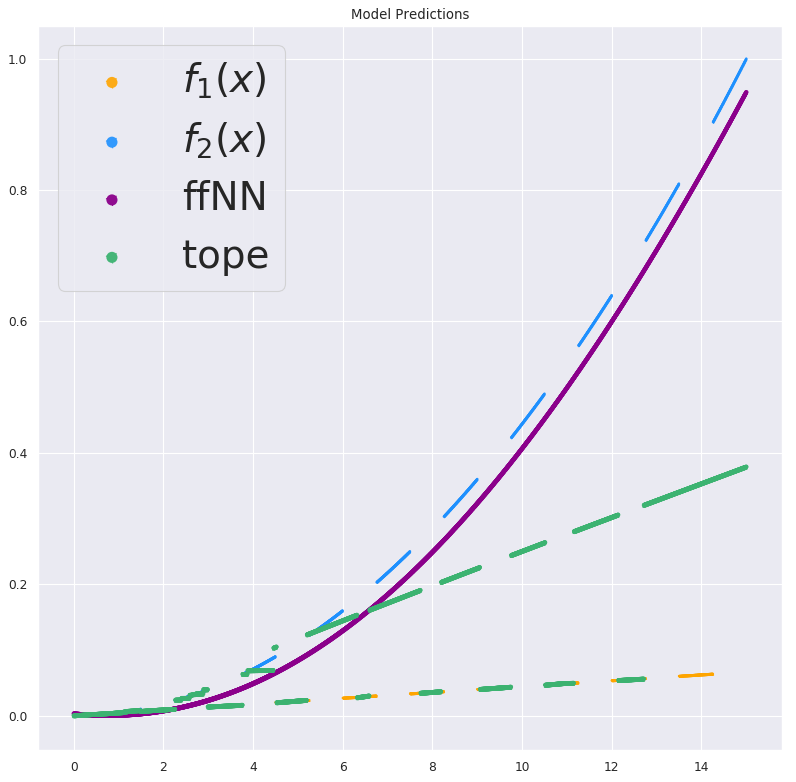

In [98]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#
# Plot Signal
# plt.scatter(x,y,color='gray',label='$f(x)$',linestyle='--')
plt.scatter(x_1,y_1,color='orange',label=r'$f_1(x)$',linestyle=(0,(1,10)),s=5,alpha=.9)
plt.scatter(x_2,y_2,color='dodgerblue',label=r'$f_2(x)$',linestyle=(0,(1,10)),s=5,alpha=.9)

#--------------------#
# Benchmark Model(s) #
#--------------------#
# Plot ffNN
plt.scatter(x,y_hat_train_Vanilla_ffNN, color = 'darkmagenta',linestyle=(0,(1,10)),  label='ffNN',s=15,alpha=.95)
plt.scatter(x,Architope_prediction_y_train, color = 'mediumseagreen',linestyle=(0,(1,10)), label='tope',s=15,alpha=.95)



# Format Plot #
#-------------#
# Plot legend.
lgnd = plt.legend(loc="upper left", scatterpoints=1, fontsize=35)
plt.title("Model Predictions")
# Format
for handle in lgnd.legendHandles:
    handle.set_sizes([100])
# plt.show()

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/DEMO_Seaborn.eps', format='eps')

---
# Fin
---